# Homework for chapter 5 in "Statistical Rethinking"

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm

from theano import shared
import statsmodels.api as sm
np.random.seed(770)

In [3]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Easy.
### 5E1.
The following linear models are **not** multiple linear regressions:
1. $\mu_i=\alpha + \beta x_i$ - This is just a linear regression with intercept on one slope.
3. $\mu_i=\alpha + \beta (x_i - z_i)$ - There is only one slope on a single feature which is "engeineerd" by reducing $z_i$ from $x_i$.

### 5E2.
To see if animal diversity is linearly related to latitude, but only after controlling for plant diversity, we'll write down a multilinear model:

1. $AnimalDiversity \sim \mathcal{N}(\mu, \sigma)$ (likelihood).
2. $\mu = \alpha + \beta_1 latitute + \beta_2 PlandDiversity$ (linear model).
3. I'll skip the description of the priors for $\sigma$, $\alpha$ and $\beta_{(1, 2)}$.

### 5E3.
We'll write a multiple regression to express the relationship between funding (FN) and laboratory size (LZ) with time to PhD (TPHD):

1. $TPHD \sim \mathcal{N}(\mu, \sigma)$ (likelihood).
2. $\mu = \alpha + \beta_1 FN + \beta_2 LZ$
3. I skip the details of the priors. $\alpha \sim \mathcal{U}, \beta_{1,2} \sim \mathcal{N}$ 

Both $beta$'s should be somewhat positive, but small. It should be beneficial to add an interaction term in the form of: $\mu = ... + \beta_3 (FN \cdot LZ)$ in this case, $\beta_3$ should be large and positive.

### 5E4. 
To fit a linear model for a categorical variable of 4 levels we need four coefficients: $\alpha$ (intercept) and $\beta_{1, 2, 3}$, otherwise the linear equation is overdetermined. Equations (1) (3) and (5) qualify for that. Note, that the terms in equation (5) need to be re-arranged to see that.

## Medium

### 5M1.
Let's invent our own model for spurious correlation:
X - is the true predictor variable.
Y - is the true outcome variable.
Y_spure - is the spurious variable, which is strongly correlated with the true predictor.

In [4]:
N = 200
df = pd.DataFrame()
df['X'] = norm.rvs(size=N)
df['Y'] = 0.1 + 0.2 * norm.rvs(loc=df['X'])
df['Y_spure'] = norm.rvs(loc=df['X'], scale=0.2)

In [5]:
mod5m1 = sm.OLS.from_formula('Y ~ X', data=df)
m5m1res = mod5m1.fit()
print('X coef: {:0.2f}, Pval: {:0.2f}'.format(m5m1res.params['X'], m5m1res.pvalues['X']))

X coef: 0.21, Pval: 0.00


In [6]:
mod5m2 = sm.OLS.from_formula('Y ~ Y_spure', data=df)
m5m2res = mod5m2.fit()
print('Y_spure coef: {:0.2f}, Pval: {:0.2f}'.format(m5m2res.params['Y_spure'], m5m2res.pvalues['Y_spure']))

Y_spure coef: 0.20, Pval: 0.00


In [7]:
mod5m3 = sm.OLS.from_formula('Y ~ X + Y_spure', data=df)
m5m3res = mod5m3.fit()
print('X coef: {:0.2f}, Pval: {:0.2f}'.format(m5m3res.params['X'], m5m3res.pvalues['X']))
print('Y_spure coef: {:0.2f}, Pval: {:0.2f}'.format(m5m3res.params['Y_spure'], m5m3res.pvalues['Y_spure']))

X coef: 0.19, Pval: 0.01
Y_spure coef: 0.01, Pval: 0.83


In mode5m2 the spurious variable `Y_spure` seems to be a good predictor of `Y`. Howeverm in mod5m3, which the true predictor `X` is added, the coefficient of `Y_spure` id diminished.

### 5M2.
Example of a masked relationship:

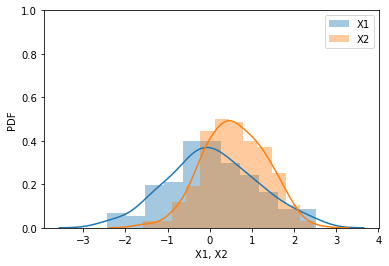

In [8]:
N = 200
df2 = pd.DataFrame()
df2['X1'] = norm.rvs(size=N)
df2['X2'] = 0.5 + 0.5*norm.rvs(loc=df2['X1'])

sns.distplot(df2['X1'], label='X1')
sns.distplot(df2['X2'], label='X2')
plt.xlabel('X1, X2')
plt.ylabel('PDF')
plt.ylim(0, 1)
plt.legend();

In [9]:
# generate the dependant variable
df2['Y'] = norm.rvs(size=N, loc=(df2['X1'] - 2*df2['X2']), scale=2)

`Y` is correlated with `X1`:

In [10]:
m521 = sm.OLS.from_formula('Y ~ X1', data=df2)
m521res = m521.fit()
print('X1 coef: {:0.2f}, Pval: {:0.2f}'.format(m521res.params['X1'], m521res.pvalues['X1']))

X1 coef: -0.02, Pval: 0.90


`Y` is correlated with `X2`:

In [11]:
m522 = sm.OLS.from_formula('Y ~ X2', data=df2)
m522res = m522.fit()
print('X2 coef: {:0.2f}, Pval: {:0.2f}'.format(m522res.params['X2'], m522res.pvalues['X2']))

X2 coef: -0.75, Pval: 0.00


`X1` and `X2` are correlated:

In [12]:
m523 = sm.OLS.from_formula('X1 ~ X2', data=df2)
m523res = m522.fit()
print('X2 coef: {:0.2f}, Pval: {:0.2f}'.format(m523res.params['X2'], m523res.pvalues['X2']))

X2 coef: -0.75, Pval: 0.00


If both predictor variables are included in the model, a stronger relationship is revealed (larger coefficients): 

In [13]:
m524 = sm.OLS.from_formula('Y ~ X2 + X1', data=df2)
m524res = m524.fit()
print('X1 coef: {:0.2f}, Pval: {:0.2f}'.format(m524res.params['X1'], m524res.pvalues['X1']))
print('X2 coef: {:0.2f}, Pval: {:0.2f}'.format(m524res.params['X2'], m524res.pvalues['X2']))

X1 coef: 0.82, Pval: 0.00
X2 coef: -1.63, Pval: 0.00


### 5M4.
Moromon population as predictor for divorce rate.

In [14]:
# grab the divorce rate from the "rethinking" github
#https://github.com/rmcelreath/rethinking
divorce = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv', delimiter=';')
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [15]:
# get the mormon population from Wikipedia
from pandas.io.html import read_html
page = 'https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States)'
wikitables = read_html(page, index_col=None, header=0, attrs={"class":"wikitable"})
wiki_lds = wikitables[0].loc[:,['State', 'LDS']] # select only these columns

wiki_lds['LDS_pct'] = wiki_lds['LDS'].str.replace('%', '')
wiki_lds['LDS_pct'] = wiki_lds['LDS_pct'].astype(np.float16)

# rename 'State' to 'Location' so that the merge operation 
# doesn't duplicates columns.
wiki_lds.rename(columns={'State': 'Location'}, inplace=True)
wiki_lds.head()

,Location,LDS,LDS_pct
0,Alabama,0.77%,0.770020
1,Alaska,4.56%,4.558594
2,Arizona,6.10%,6.101562
3,Arkansas,1.03%,1.030273
4,California,1.97%,1.969727


In [16]:
# Merge in to `divorce` data from wikipedia
divorce2 = pd.merge(divorce, wiki_lds, on='Location')

# rename columns with spaces. Statsmodels doesn't like that.
divorce2.rename(columns={'Divorce SE': 'Divorce_SE', 'Marriage SE': 'Marriage_SE'}, inplace=True)

Now, let's make a model to predict divorce rate based on: (1) marriage rate (2) median age at marriage, and (3) percent LDS population. Actually we'll make two models, the first without population precent of LDS and then with: 

In [17]:
m541 = sm.OLS.from_formula('Divorce ~ standardize(Marriage) + standardize(MedianAgeMarriage)', data=divorce2)
m541res = m541.fit()
m541res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                   OLS                  Adj. R-squared:         0.336   
Dependent Variable:      Divorce              AIC:                    184.2276
Date:                    2017-11-23 15:14     BIC:                    189.9637
No. Observations:        50                   Log-Likelihood:         -89.114 
Df Model:                2                    F-statistic:            13.42   
Df Residuals:            47                   Prob (F-statistic):     2.46e-05
R-squared:               0.363                Scale:                  2.2002  
------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                       9.6880   0.2098 46.1836 0.0000  9.2660 10.1100
standardize(Marriage)          -0.2138   0.3028 -0.7061 0.4836 -0.8229  0.3953
standardize(MedianAgeMarriage) -1.2307   0.3028 -4.0648 0.0002 -1.8398 -0.6216
------------------------------------------------------------------------------
Omnibus:                  2.545             Durbin-Watson:               1.903
Prob(Omnibus):            0.280             Jarque-Bera (JB):            1.595
Skew:                     -0.301            Prob(JB):                    0.450
Kurtosis:                 3.635             Condition No.:               2    
==============================================================================

"""

In [18]:
m542 = sm.OLS.from_formula('Divorce ~  standardize(Marriage) + standardize(MedianAgeMarriage) + standardize(LDS_pct)', data=divorce2)
m542res = m542.fit()
m542res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                   OLS                  Adj. R-squared:         0.412   
Dependent Variable:      Divorce              AIC:                    179.1049
Date:                    2017-11-23 15:14     BIC:                    186.7530
No. Observations:        50                   Log-Likelihood:         -85.552 
Df Model:                3                    F-statistic:            12.44   
Df Residuals:            46                   Prob (F-statistic):     4.38e-06
R-squared:               0.448                Scale:                  1.9496  
------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                       9.6880   0.1975 49.0626 0.0000  9.2905 10.0855
standardize(Marriage)           0.0076   0.2970  0.0258 0.9796 -0.5901  0.6054
standardize(MedianAgeMarriage) -1.3631   0.2893 -4.7111 0.0000 -1.9455 -0.7807
standardize(LDS_pct)           -0.6192   0.2333 -2.6538 0.0109 -1.0889 -0.1495
------------------------------------------------------------------------------
Omnibus:                  1.133             Durbin-Watson:               1.911
Prob(Omnibus):            0.567             Jarque-Bera (JB):            0.456
Skew:                     -0.145            Prob(JB):                    0.796
Kurtosis:                 3.368             Condition No.:               3    
==============================================================================

"""

We can see, that adding `LDS_pct` as predicting variable increases the coefficient of `MedianAgeMarriage` from -1.24 to -1.38, the coefficient of `Marriage` is now even closer to 0. `LDS_pct` is found the be quite significant with pvalue < 0.011.


Let's go full bayesian:

In [21]:
modMC541 = pm.Model()

with modMC541:

    pm.glm.GLM.from_formula('Divorce ~  standardize(Marriage) + \
                            standardize(MedianAgeMarriage) + \
                            standardize(LDS_pct)', divorce2)

    trace_modMC541 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 551.69it/s]


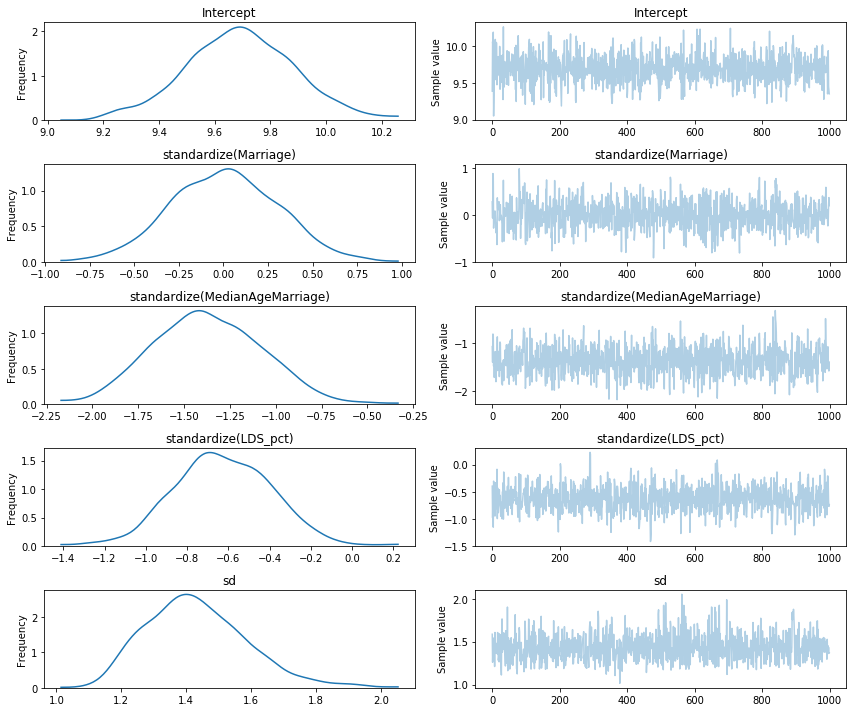

In [24]:
pm.traceplot(trace_modMC541);

In [44]:
pm.summary(trace_modMC541)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.689            0.193            0.005            [9.284, 10.063]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.286          9.557          9.688          9.822          10.070


standardize(Marriage):

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.003            0.299            0.009            [-0.571, 0.585]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.579         -0.206         0.002          0.209          0.582


standardize(MedianAgeMarriage):

  Mean             SD               MC Error     

The MCMC results are in agreement with the conventional analysis.
#### Conclusion
Accounting for the precentage of mormons in the population, shows that it's ignificant and negativly associated with devorce rate. Also, it appears that it's associated with the Median Age Marriage, and both are significant predictors of divorce rate.

### 5M5.

To explain the observation that increased gasoline prices are linked to reduced  obesity, two mechanisms are suggested:

- increased prices -> less driving -> more exercise -> less obesity.
- increased prices -> less driving -> less huge resaruant meals -> less obesity.

To figure out which machanism is required, we would need to followind data:

* Gasoline prices.
* Average (median?) driving distance.
* Average (median?) walking distance.
* Num. of restarunt meals.
* %obesity.

First, we'll have to see whether ave. driving distance is proportional to gasoline prices. Hopfully this will result in some linear relationship. 

Second, we'll make the following linear regression models:
1. obesity ~ walking (negative slope).
2. obesity ~ resaruant meals (positive slope).

Since obesity is linked to both ave. walking distance and resaruant meals by positive and negative slopes, and by themselves walking and resaruant are proportional to gasoline prices, this is potentially a masked relationship situation. We can check then by making the following model:

3. obesity ~ walking + resaruant meals.

The coefficents (slopes) for both explenatory variables should increase in their absolute size.

In [5]:
# grab the "foxes" data from the "rethinking" github
#https://github.com/rmcelreath/rethinking
foxes = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
foxes.head(2)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84


In [6]:
foxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
group        116 non-null int64
avgfood      116 non-null float64
groupsize    116 non-null int64
area         116 non-null float64
weight       116 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.6 KB


## Hard
### 5H1.
Bivariate regression - body weight as a linear function of territory size (area):

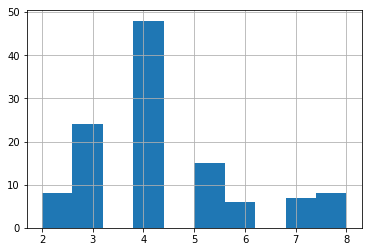

In [17]:
foxes.groupsize.hist();

In [10]:
modMC5H11 = pm.Model()

with modMC5H11:

    pm.glm.GLM.from_formula('weight ~ area', foxes)

    modMC5H11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/nbuser/.theano/compiledir_Linux-4.11--azure-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir/lock
100%|██████████| 2000/2000 [00:05<00:00, 373.96it/s]


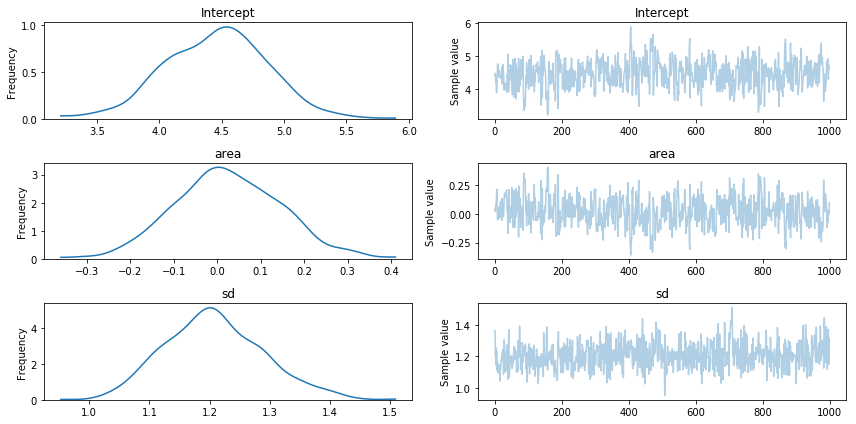

In [13]:
pm.traceplot(modMC5H11);

body weight as a linear function of groupsize

In [11]:
modMC5H12 = pm.Model()

with modMC5H12:

    pm.glm.GLM.from_formula('weight ~ groupsize', foxes)

    modMC5H12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 469.66it/s]
